In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment3/'
# FOLDERNAME = 'CS348K Final Project/cs348k-project/'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# import os
# project_path = os.path.join('/content/drive/My Drive', FOLDERNAME)
# assert os.path.exists(project_path), "[!] The specified folder does not exist in Google Drive."


# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))



In [2]:
from sample import BaseModel, train_predictor, train_selector
from sample import PredictorNetwork
from sample import SelectorNetwork
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [18]:
"""Set up the DataLoaders: """
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the transformation for the validation data
transform = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the validation dataset
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the full CIFAR-10 training dataset
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the sizes for training and validation datasets (80/20 split)
train_size = 6400 #int(0.1 * len(full_train_dataset)) # 6400
val_size = len(full_train_dataset) - train_size

# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Define the DataLoader for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the CIFAR-10 test datase
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

test_size = int(0.1 * len(test_dataset))
_, small_test_dataset = random_split(test_dataset, [len(test_dataset) - test_size, test_size])

test_loader = DataLoader(small_test_dataset, batch_size=32, shuffle=False)

# Print the sizes of the datasets
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(small_test_dataset)}')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training dataset size: 6400
Validation dataset size: 43600
Test dataset size: 1000


In [19]:
# Instantiate models, criterion, and optimizer
# base_model = BaseModel()
base_model = BaseModel()
base_model.eval()
num_classes = 10 # CIFAR10

# Load the pretrained ResNet-50 model
resnet50 = models.resnet50(pretrained=True) # pretrained on ImageNet
# resnet50.eval() # sets this to evaluation mode

resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes) #rewrites resnet18 final fc layer




In [20]:
import torch
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset

# Dictionary to store hooks
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Load the pretrained ResNet18 model
resnet18 = models.resnet18(pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18 = resnet18.to(device)
resnet18.eval()

# Register hooks on the layers of interest
hook_handles = []
hook_handles.append(resnet18.layer1.register_forward_hook(get_activation('layer1')))
hook_handles.append(resnet18.layer2.register_forward_hook(get_activation('layer2')))
hook_handles.append(resnet18.layer3.register_forward_hook(get_activation('layer3')))
hook_handles.append(resnet18.layer4.register_forward_hook(get_activation('layer4')))
hook_handles.append(resnet18.fc.register_forward_hook(get_activation('fc')))

# Transformation and data loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize lists to collect layer outputs and correctness
layer1_list, layer2_list, layer3_list, layer4_list, fc_list = [], [], [], [], []
outputs_list, binary_list = [], []

with torch.no_grad():
    for images, labels in train_loader: # train_size 
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet18(images)

        # Append activations
        layer1_list.append(activation['layer1'].flatten())
        layer2_list.append(activation['layer2'].flatten())
        layer3_list.append(activation['layer3'].flatten())
        layer4_list.append(activation['layer4'].flatten())
        fc_list.append(activation['fc'].flatten())

        # Append predictions and correctness
        softmax_outputs = F.softmax(outputs, dim=1)
        _, preds = torch.max(softmax_outputs, 1)
        binary_list.extend((preds == labels).cpu().numpy())

# Detach hooks
for handle in hook_handles:
    handle.remove()


# Save tensors if needed
# torch.save(layer1_tensor, 'layer1_tensor.pth')
# torch.save(layer2_tensor, 'layer2_tensor.pth')
# torch.save(layer3_tensor, 'layer3_tensor.pth')
# torch.save(layer4_tensor, 'layer4_tensor.pth')
# torch.save(fc_tensor, 'fc_tensor.pth')
# torch.save(binary_tensor, 'binary_tensor.pth')

import torch
from torch.utils.data import Dataset, DataLoader


# Create custom datasets
class PredictorDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

class SelectorDataset(Dataset):
    def __init__(self, predictions, corrects):
        self.predictions = predictions
        self.corrects = corrects

    def __len__(self):
        return len(self.predictions)

    def __getitem__(self, idx):
        return self.predictions[idx], self.corrects[idx]

# Create datasets
predictor_layer1_dataset = PredictorDataset(layer1_list, fc_list)
predictor_layer2_dataset = PredictorDataset(layer2_list, fc_list)
predictor_layer3_dataset = PredictorDataset(layer3_list, fc_list)
predictor_layer4_dataset = PredictorDataset(layer4_list, fc_list)
selector_dataset = SelectorDataset(fc_list, binary_list)

# Create dataloaders
batch_size = 32
predictor_layer1_data_loader = DataLoader(predictor_layer1_dataset, batch_size=batch_size, shuffle=True)
predictor_layer2_data_loader = DataLoader(predictor_layer2_dataset, batch_size=batch_size, shuffle=True)
predictor_layer3_data_loader = DataLoader(predictor_layer3_dataset, batch_size=batch_size, shuffle=True)
predictor_layer4_data_loader = DataLoader(predictor_layer4_dataset, batch_size=batch_size, shuffle=True)
selector_data_loader = DataLoader(selector_dataset, batch_size=batch_size, shuffle=True)

# Define the predictor and selector networks
class FCPredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.fc(x)

class SelectorNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SelectorNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)


In [16]:
print(activation['layer1'].shape)
print(activation['layer2'].shape)
print(activation['layer3'].shape)
print(activation['layer4'].shape)
print(activation['fc'].shape)

torch.Size([8, 64, 8, 8])
torch.Size([8, 128, 4, 4])
torch.Size([8, 256, 2, 2])
torch.Size([8, 512, 1, 1])
torch.Size([8, 1000])


In [21]:

# Example training function for predictor and selector networks
def train_predictor(model, dataloader, epochs=10):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    model.train()
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")
        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)
    return loss_history

def train_selector(model, dataloader, epochs=10):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    model.train()
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")
        epoch_loss = running_loss / len(dataloader)
        loss_history.append(epoch_loss)
    return loss_history


# Example training for one predictor and selector
input_dim = layer1_list[0].shape[0] # Adjust based on the actual shape
output_dim = fc_list[0].shape[0]  # Number of classes, e.g., 10 for CIFAR-10

# Create and train predictor network for layer1 outputs
predictor_model = FCPredictor(input_dim, output_dim).to(device)
predictor_loss = train_predictor(predictor_model, predictor_layer1_data_loader)

# Create and train selector network
selector_model = SelectorNetwork(output_dim).to(device)
selector_loss = train_selector(selector_model, selector_data_loader)


Epoch 1, Loss: 4.245792320796421
Epoch 2, Loss: 4.236752850668771
Epoch 3, Loss: 4.203541346958706
Epoch 4, Loss: 4.183003085000174
Epoch 5, Loss: 4.189755780356271
Epoch 6, Loss: 4.203504630497524
Epoch 7, Loss: 4.188083239964077
Epoch 8, Loss: 4.18192195892334
Epoch 9, Loss: 4.221247945513044
Epoch 10, Loss: 4.183719430650983
Epoch 1, Loss: 0.6126282215118408
running loss:  4.288397550582886
Epoch 2, Loss: 0.43620212588991436
running loss:  3.0534148812294006
Epoch 3, Loss: 0.32096939853259493
running loss:  2.2467857897281647
Epoch 4, Loss: 0.2353281889642988
running loss:  1.6472973227500916
Epoch 5, Loss: 0.16974058960165297
running loss:  1.1881841272115707
Epoch 6, Loss: 0.1274676269718579
running loss:  0.8922733888030052
Epoch 7, Loss: 0.10030410651649747
running loss:  0.7021287456154823
Epoch 8, Loss: 0.08342923649719783
running loss:  0.5840046554803848
Epoch 9, Loss: 0.06404770484992436
running loss:  0.4483339339494705
Epoch 10, Loss: 0.05441096744367054
running loss:  0.

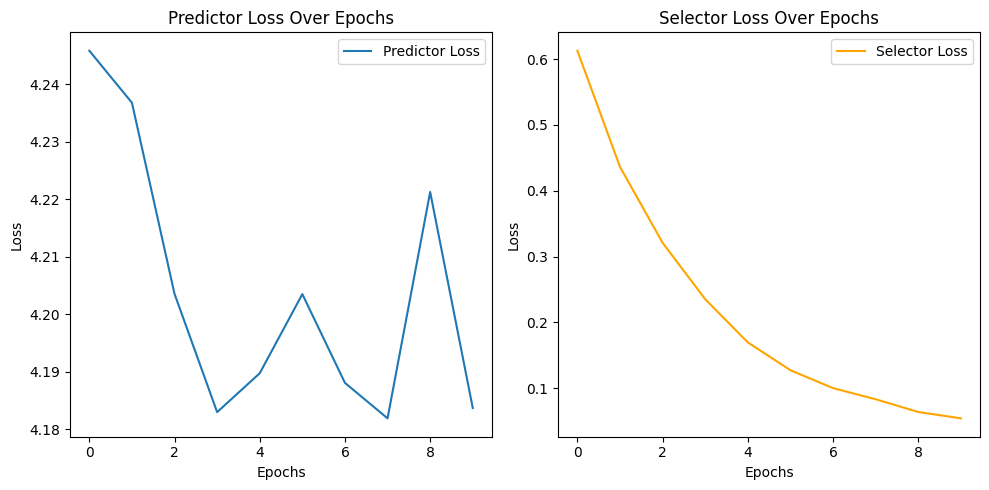

In [22]:
import matplotlib.pyplot as plt
#Plotting the Loss: 
# Plotting the loss history
plt.figure(figsize=(10, 5))

# Plot predictor loss
plt.subplot(1, 2, 1)
plt.plot(predictor_loss, label='Predictor Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Predictor Loss Over Epochs')
plt.legend()

# Plot selector loss
plt.subplot(1, 2, 2)
plt.plot(selector_loss, label='Selector Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Selector Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
